In [1]:
import os
import sys
import math
import operator
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import gridmap_config as c

from IPython.display import display, HTML
from tabulate import tabulate
from shapely.geometry import Polygon, Point
from math import sqrt
from shapely.affinity import translate

In [2]:
tile_id = 'tile_id'
admin_id = 'admin_id'
admin_id_admin = 'admin_id_admin'
admin_id_tile = 'admin_id_tile'
jo_tile = 'join_order_tile'
jo_admin = 'join_order_admin'

In [3]:
polys = c.kenya_counties_msSimplified
polys = c.USA_extraSimp
#keep_flds = ['County', 'CID'] #Kenya
keep_flds = ['NAME_1', admin_id] #USA
os.path.isfile(polys)

True

In [4]:
admin = gpd.read_file(polys).to_crs({'init': 'epsg:5070'})
admin[admin_id] = admin['HASC_1'].str.split('.').str[1]
admin = admin.sort_values(by='NAME_1').reset_index(drop=True)
admin = admin.rename(columns={'geometry': 'geom_poly'}).set_geometry('geom_poly')
keep_flds.append(admin.geometry.name)
del_flds = [x for x in list(admin) if x not in keep_flds]
admin.drop(columns=del_flds, inplace=True)
admin.head(3)

,NAME_1,geom_poly,admin_id
0,Alabama,"POLYGON ((728281.9053291343 842366.7899221318,...",AL
1,Arizona,POLYGON ((-1733371.378979061 1243103.444279246...,AZ
2,Arkansas,"POLYGON ((181441.7024997548 1107458.717934108,...",AR


In [34]:
def display_point_labels(gdf, label_col, fs=10, c='blue'):
    texts = []
    for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf[label_col]):
        texts.append(plt.text(x, y, label, fontsize=fs, color=c))

def add_centroid_geom(gdf):
    gdf['geom_centroid'] = gdf.centroid
    return gdf

def add_convexhull_geom(gdf):
    gdf['geom_convexhull'] = gdf.convex_hull
    return gdf

def dissolve_polygons(gdf):
    gdf['dissolve_col'] = 1
    gdf_dissolve = gdf.dissolve(by='dissolve_col')
    gdf_dissolve['geom_exterior'] = Polygon(gdf_dissolve.exterior[1])
    gdf_dissolve = gdf_dissolve.set_geometry('geom_exterior')
    gdf_dissolve['geom_centroid'] = gdf_dissolve.centroid
    return gdf_dissolve

admin = add_centroid_geom(admin)
admin = add_convexhull_geom(admin)
admin_hulls_dissolved = dissolve_polygons(admin.set_geometry('geom_convexhull'))

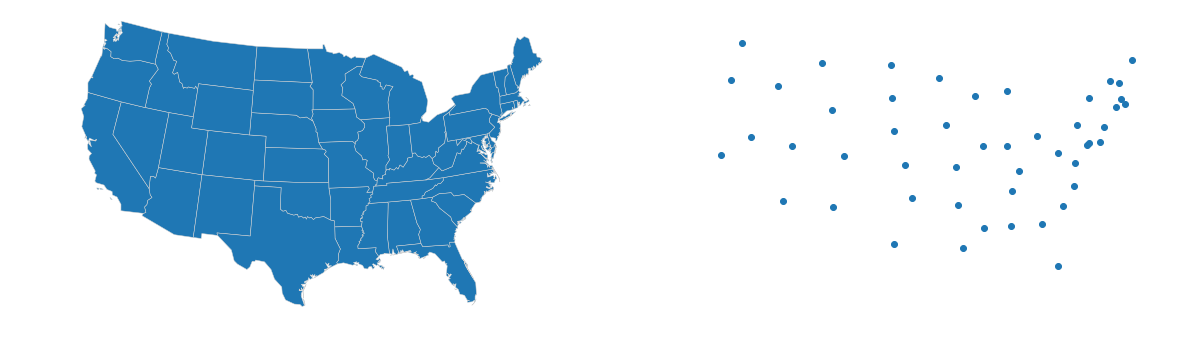

In [6]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin.set_geometry('geom_centroid').plot(ax=ax2)

plt.show()

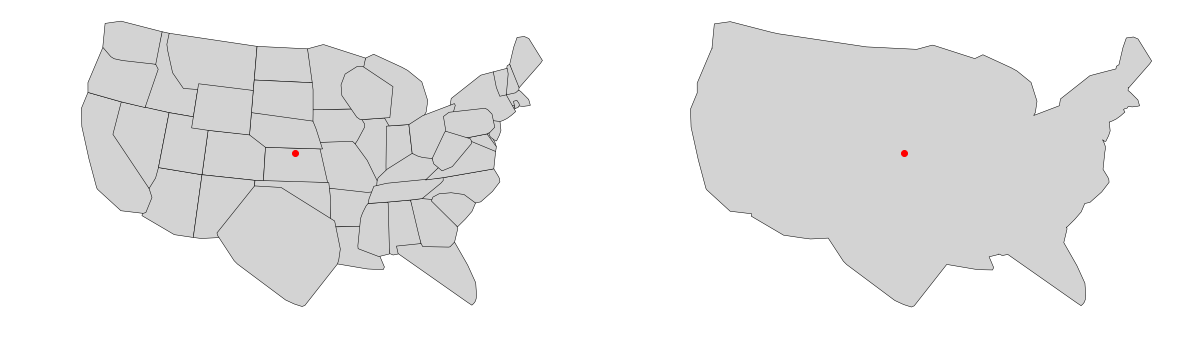

In [7]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 20), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_convexhull').plot(ax=ax1, linewidth=0.5, edgecolor='black', color='lightgrey')
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax1, color='red')

# Plot on axis 2 (right)
ax2.set_axis_off()
admin_hulls_dissolved.plot(ax=ax2, linewidth=0.5, edgecolor='black', color='lightgrey')
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax2, color='red')

plt.show()

In [8]:
def round_dict_vals(dictionary, places=10):
    for k, v in dictionary.items():
        dictionary[k] = float(round(dictionary[k], places))
    return dictionary

def get_bounding_coordinates(gpd, round_nums=True):
    tb = gpd.total_bounds
    total_bounds = {'minx': tb[0],
                    'miny': tb[1],
                    'maxx': tb[2],
                    'maxy': tb[3],
                    'rangex': abs(tb[0] - tb[2]),
                    'rangey': abs(tb[1] - tb[3])}
    if round_nums:
        total_bounds = round_dict_vals(total_bounds)
    
    return total_bounds

def build_bounding_polygon(extent, crs):
    BL = (extent['minx'], extent['miny'])
    BR = (extent['maxx'], extent['miny'])
    TR = (extent['maxx'], extent['maxy'])
    TL = (extent['minx'], extent['maxy'])
    corners = [BL, BR, TR, TL]
    rectangle = gpd.GeoDataFrame(pd.DataFrame({'geometry': [Polygon(corners)]}), geometry='geometry', crs=crs)
    
    return rectangle
    
bbox = get_bounding_coordinates(admin.set_geometry('geom_poly'))
bbox_gdf = build_bounding_polygon(bbox, admin.crs)
bbox

{'minx': -2354015.2549957507,
 'miny': 311383.0413461132,
 'maxx': 2258357.676058443,
 'maxy': 3165734.0597565253,
 'rangex': 4612372.9310541935,
 'rangey': 2854351.018410412}

In [9]:
def displace_vertex(x, y, length, angle):
    '''
    calculates new point up to a given distance away
    from original point. All values should be provided
    in meters

    point = (x,y)
    '''
    #The number pi
    PI = 3.1415926535

    #Convert the random angle from degrees to radians
    angle_radian = (angle) * (PI/180)

    #Generate the offset by applying trig formulas (law of cosines) 
    #using the distance as the hypotenuse solving for the other sides
    xOffset = math.sin(angle_radian) * length
    yOffset = math.cos(angle_radian) * length

    #Add the offset to the orginal coordinate
    new_x = x + xOffset
    new_y = y + yOffset

    return (new_x, new_y) 

def build_hexagon(x, y, length, bearing):
    pts = [(x,y)]
    
    for pt in range(0,5):
        x, y = displace_vertex(x, y, length, bearing)
        bearing += 60
        pts.append((x,y))
    hex_poly = Polygon(pts)
    return hex_poly

def tesselate_hexagons_translate(bb, hull, length, x_offset_factor, y_offset_factor, flat='up'):
    x_row = 100
    y_col = 0
    hexes = []
    x_offset_seed = x_offset_factor * length
    y_offset_seed = y_offset_factor * length
    
    # flat='up' means flat sides are up and down
    # flat='side' means flat sides are on the sides
    if flat=='up':
        bearing = 30
        next_start_pt_idx = 3
    elif flat=='side':
        bearing = 0
        next_start_pt_idx = 4
    else:
        raise Exception('Acceptable parameters for flat: \'up\' and \'side\'')
    
    hexagon_seed = build_hexagon(bb['minx'] + x_offset_seed, bb['miny'] + y_offset_seed, length, bearing)
    hexagon = hexagon_seed
    
    row=1
    shift = 1
    xy_inside_bbox = True
    while xy_inside_bbox:
        y_col += 1
        hex_gdf = gpd.GeoDataFrame(pd.DataFrame({'geom_poly': [hexagon]}), geometry='geom_poly')
        hex_gdf[tile_id] = (x_row + y_col)
        centroid = hexagon.centroid

        x_inside = ((centroid.x >= bb['minx'] - abs(x_offset_seed)) and
                    (centroid.x <= bb['maxx'] + abs(x_offset_seed)))
        y_inside = ((centroid.y >= bb['miny'] - abs(y_offset_seed)) and
                    (centroid.y <= bb['maxy'] + abs(y_offset_seed)))
        
        if hull.intersects(centroid):
            hexes += [hex_gdf]
        
        if x_inside and y_inside:
            if flat == 'up':     
                move_x = 3 * length
            elif flat == 'side': 
                move_x = sqrt(3) * length     
            move_y = 0
                
        elif not x_inside and y_inside:
            hexagon = hexagon_seed
            if flat == 'up':
                if row%2 == 0: #Every other row
                    move_y = (sqrt(3) * length * shift) + y_offset_seed
                    move_x = 0 + x_offset_seed
                    shift+=1 
                else:
                    move_y = (((sqrt(3) * length) * shift) - (0.5 * sqrt(3) * length))  + y_offset_seed
                    move_x = (length * 1.5) + x_offset_seed
           
            elif flat == 'side':
                if row%2 == 0: #Every other row
                    move_y = 1.5 * length * row
                    move_x = 0#  + x_offset_seed
                else:
                    move_y = 1.5 * length * row
                    move_x = -((0.5 * sqrt(3) * length))# + x_offset_seed)
            x_row += 100
            y_col = 0
            row+=1
            
        else:
            xy_inside_bbox = False
        
        hexagon = translate(hexagon, xoff=move_x, yoff=move_y)
    
    hexes_gdf = gpd.GeoDataFrame(pd.concat(hexes, ignore_index=True, sort=False), crs=hexes[0].crs, geometry='geom_poly')
    hexes_gdf = add_centroid_geom(hexes_gdf)
    return hexes_gdf
    
def iterate_size(adm, bb, flat, x_offset_factor, y_offset_factor, len_factor, iter_factor): #x_offset_factor should be between -1 and 1
    length = max(bb['rangex'], bb['rangey']) / (len(adm) * len_factor)
    print('\nFlat side: {}'.format(flat))
    
    hex_count = len(adm) + 1
    i = 1
    while hex_count > len(adm):
        hexagons = tesselate_hexagons_translate(bb=bbox, 
                                                hull=admin_hulls_dissolved['geom_convexhull'][1], 
                                                length=length,
                                                x_offset_factor=x_offset_factor,
                                                y_offset_factor=y_offset_factor,
                                                flat=flat)
        hex_count = len(hexagons)
        
        print('i{} h{}...'.format(i, hex_count), end =' ')
        length = length * iter_factor
        i+=1

    return hexagons

xofac1 = 0.2
yofac1 = 0.2
xofac2 = -1
yofac2 = 0
lfac   = 0.38
ifac   = 1.0009

hexagons_up = iterate_size(admin, bbox, flat='up', 
                           x_offset_factor=xofac1, y_offset_factor=yofac1, 
                           len_factor=lfac, iter_factor=ifac)

hexagons_side = iterate_size(admin, bbox, flat='side', 
                             x_offset_factor=xofac2, y_offset_factor=yofac2, 
                             len_factor=lfac, iter_factor=ifac)

hexagons_up.head(10)


Flat side: up
i1 h53... i2 h54... i3 h54... i4 h54... i5 h54... i6 h54... i7 h54... i8 h54... i9 h54... i10 h54... i11 h54... i12 h54... i13 h52... i14 h52... i15 h52... i16 h52... i17 h51... i18 h50... i19 h50... i20 h49... 
Flat side: side
i1 h52... i2 h52... i3 h52... i4 h51... i5 h51... i6 h51... i7 h50... i8 h50... i9 h50... i10 h50... i11 h51... i12 h51... i13 h51... i14 h51... i15 h51... i16 h51... i17 h51... i18 h51... i19 h51... i20 h51... i21 h51... i22 h51... i23 h51... i24 h52... i25 h53... i26 h53... i27 h53... i28 h53... i29 h53... i30 h52... i31 h52... i32 h52... i33 h52... i34 h52... i35 h52... i36 h52... i37 h51... i38 h51... i39 h50... i40 h50... i41 h50... i42 h50... i43 h50... i44 h50... i45 h49... 

,geom_poly,tile_id,geom_centroid
0,"POLYGON ((-363365.17769296 630397.4170310232, ...",203,POINT (-111384.1552408598 630397.4170322802)
1,"POLYGON ((1148520.956967387 630397.4170310232,...",205,POINT (1400501.979419488 630397.4170322802)
2,POLYGON ((-741336.7113580466 848619.3837385769...,303,POINT (-489355.6889059466 848619.3837398337)
3,"POLYGON ((14606.35597212706 848619.3837385769,...",304,POINT (266587.378424227 848619.3837398337)
4,"POLYGON ((770549.4233023007 848619.3837385769,...",305,POINT (1022530.445754401 848619.3837398337)
5,"POLYGON ((-1119308.245023134 1066841.35044613,...",402,POINT (-867327.2225710334 1066841.350447387)
6,"POLYGON ((-363365.17769296 1066841.35044613, -...",403,POINT (-111384.1552408598 1066841.350447387)
7,"POLYGON ((392577.8896372137 1066841.35044613, ...",404,POINT (644558.912089314 1066841.350447387)
8,"POLYGON ((1148520.956967387 1066841.35044613, ...",405,POINT (1400501.979419488 1066841.350447387)
9,"POLYGON ((-1497279.77868822 1285063.317153684,...",502,POINT (-1245298.75623612 1285063.317154941)


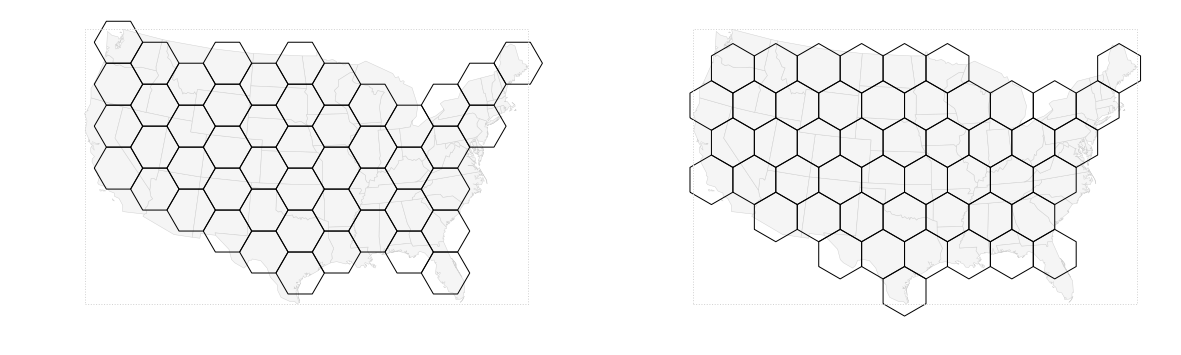

In [10]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 16), sharex=True, sharey=True)

# Plot on axis 1 (left)
ax1.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax1, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons_up.plot(ax=ax1, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax1, facecolor="none", edgecolor='lightgrey', linestyle=':')
#pt.plot(ax=ax1, color='red')

# Plot on axis 2 (left)
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
hexagons_side.plot(ax=ax2, edgecolor='black', facecolor="none")
bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')

plt.show()

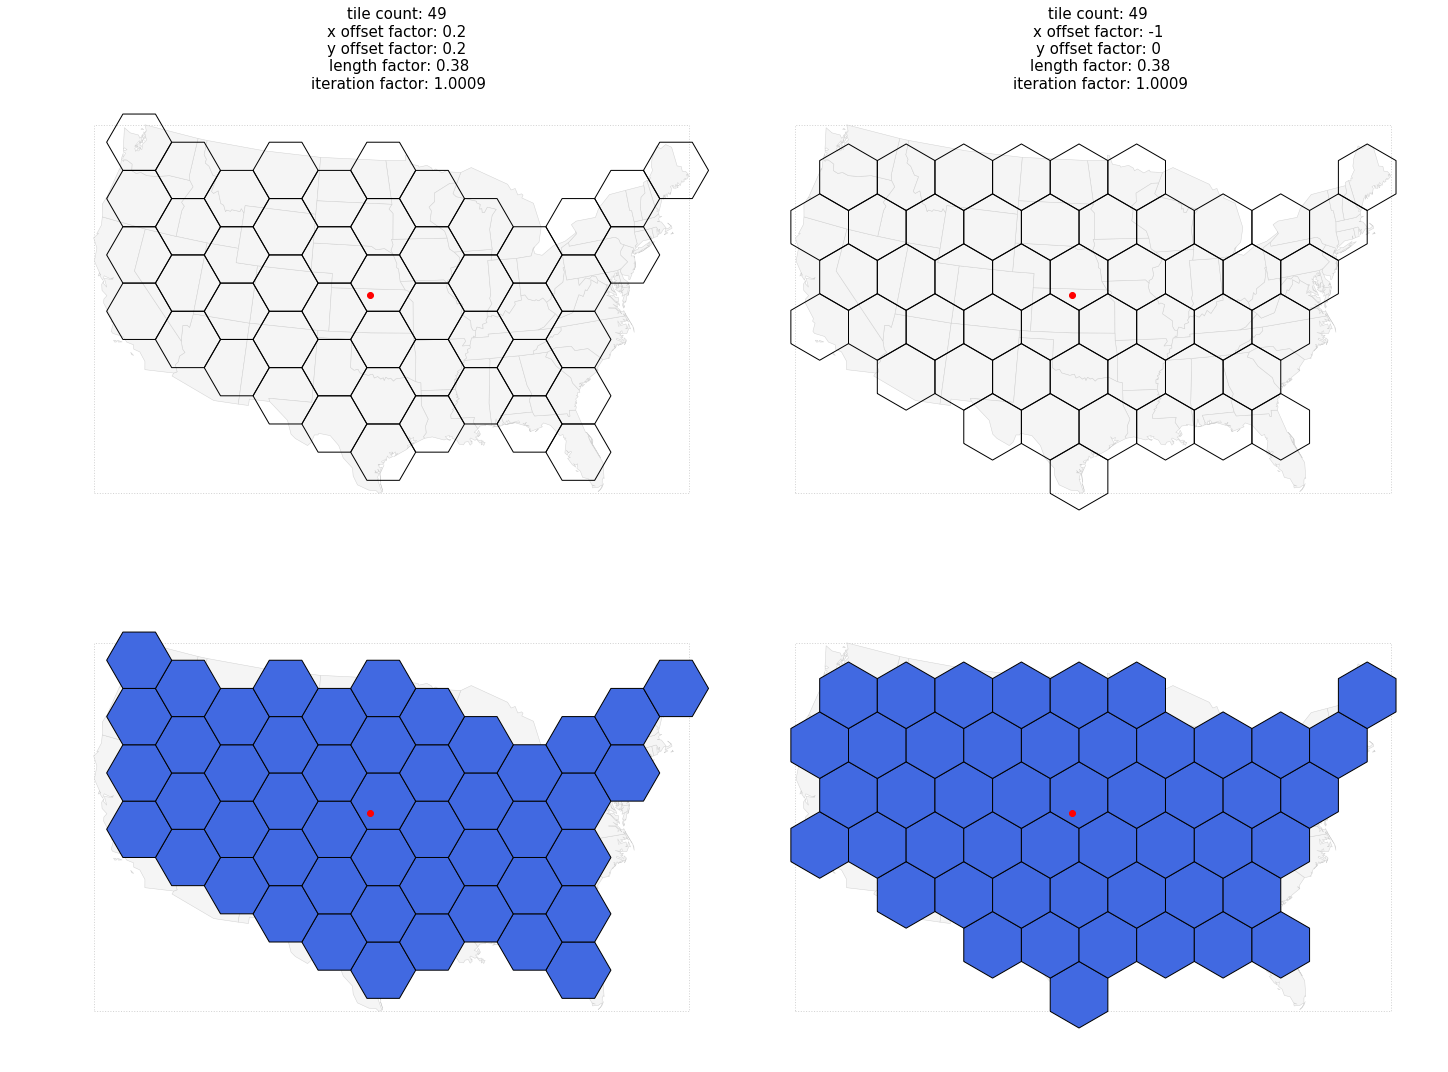

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(20, 15), sharex=True, sharey=True)

# Plot on axis 1 (top left)
ax[0,0].set_title('tile count: {} \nx offset factor: {} \ny offset factor: {} \nlength factor: {}\niteration factor: {}'.format(len(hexagons_up), xofac1, yofac1, lfac, ifac), 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax[0,0].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[0,0], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[0,0], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_up.plot(ax=ax[0,0], edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[0,0], color='red')

# Plot on axis 2 (top right)
ax[0,1].set_title('tile count: {} \nx offset factor: {} \ny offset factor: {} \nlength factor: {}\niteration factor: {}'.format(len(hexagons_up), xofac2, yofac2, lfac, ifac), 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax[0,1].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[0,1], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[0,1], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_side.plot(ax=ax[0,1], edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[0,1], color='red')

# Plot on axis 3 (bottom left)
ax[1,0].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[1,0], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[1,0], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_up.plot(ax=ax[1,0], edgecolor='black', facecolor="royalblue")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[1,0], color='red')

# Plot on axis 4 (bottom right)
ax[1,1].set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax[1,1], linewidth=0.5, edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax[1,1], facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_side.plot(ax=ax[1,1], edgecolor='black', facecolor="royalblue")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax[1,1], color='red')

plt.show()

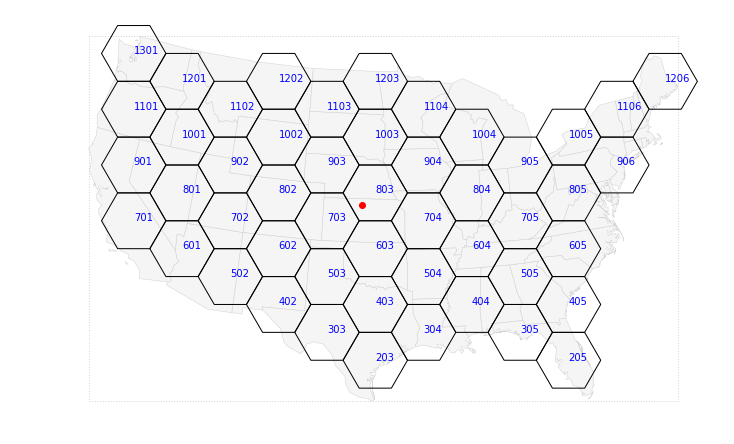

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_up.plot(ax=ax, edgecolor='black', facecolor="none")
admin_hulls_dissolved.set_geometry('geom_centroid').plot(ax=ax, color='red')
#hexagons_up.set_geometry('geom_centroid').plot(ax=ax, color='lightblue')
#display_point_labels(admin.set_geometry('geom_centroid'), admin_id, c='black')
display_point_labels(hexagons_up.set_geometry('geom_centroid'), tile_id)

#admin.set_geometry('geom_centroid').plot(ax=ax, color='green')

In [13]:
def dist_to_centroid_fld(centers, centroid, idx_col, order_col):
    distances = {}
    centroid_pt = centroid['geom_centroid'][1] #Get Shapely point geom from geodataframe
    
    try:
        centers.drop(columns=['dist_to_centroid', order_col], inplace=True)
    except:
        pass
        
    for i, row in centers.iterrows():
        pt = row['geom_centroid']
        idx = row[idx_col] 
        distance = pt.distance(centroid_pt)
        distances[idx] = distance
        #print('{}  {}  {}'.format(i, idx, distance))
        
    distances_dict = dict(sorted(distances.items(), key=operator.itemgetter(1), 
                                 reverse=True))
    distances_df = pd.DataFrame(list(distances_dict.items()), 
                                columns=[idx_col, 'dist_to_centroid'])
    distances_df[order_col] = distances_df.index
    centers = centers.join(distances_df.set_index(idx_col), 
                           on=idx_col).sort_values(by=[order_col]).reset_index(drop=True)

    return centers

def build_admin_tile_distance_df(admin_centers, tile_centers):
    cols = [admin_id, tile_id, 'distance']
    df_dist = pd.DataFrame(columns=cols, dtype=int)
    
    for idx1, admin_row in admin_centers.iterrows():
        admin_pt = admin_row['geom_centroid']
        admin_idx = admin_row[admin_id]
        
        for idx2, tile_row in tile_centers.iterrows():
            tile_pt = tile_row['geom_centroid']
            tile_idx = tile_row[tile_id]
            distance = tile_pt.distance(admin_pt)
            #print(distance)
            
            df_tmp = pd.DataFrame([[admin_idx, tile_idx, distance]], columns=cols)
            df_dist = df_dist.append(df_tmp, ignore_index=True)
            
    return df_dist

admin = dist_to_centroid_fld(admin, admin_hulls_dissolved, admin_id, jo_admin)
hexagons_up = dist_to_centroid_fld(hexagons_up, admin_hulls_dissolved, tile_id, jo_tile)
distance_df = build_admin_tile_distance_df(admin, hexagons_up)

display(HTML(admin[[admin_id, jo_admin]].head(5).to_html()))
display(HTML(hexagons_up[[tile_id, jo_tile]].head(5).to_html()))
display(HTML(distance_df.head(5).to_html()))

display(HTML(admin.head(5).to_html()))
display(HTML(hexagons_up.head(5).to_html()))

,admin_id,join_order_admin
0,ME,0
1,NH,1
2,RI,2
3,MA,3
4,VT,4


,tile_id,join_order_tile
0,1206,0
1,1301,1
2,1106,2
3,205,3
4,906,4


,admin_id,tile_id,distance
0,ME,1206.0,9.492331e+04
1,ME,1301.0,4.075857e+06
2,ME,1106.0,3.435575e+05
3,ME,205.0,2.251477e+06
4,ME,906.0,6.865721e+05


,NAME_1,geom_poly,admin_id,geom_centroid,geom_convexhull,dist_to_centroid,join_order_admin
0,Maine,"(POLYGON ((2012079.470793712 2514546.60862861,...",ME,POINT (2066949.705286145 2780978.2158422),"POLYGON ((2027301.853675826 2501995.251230628,...",2.463455e+06,0
1,New Hampshire,"POLYGON ((1897124.507791923 2428472.05425583, ...",NH,POINT (1938726.853919199 2549555.582788726),"POLYGON ((1897124.507791923 2428472.05425583, ...",2.263236e+06,1
2,Rhode Island,(POLYGON ((2028326.287388492 2324362.981159392...,RI,POINT (1995068.94720282 2335162.037647525),"POLYGON ((1984289.685364628 2292892.109343662,...",2.261240e+06,2
3,Massachusetts,(POLYGON ((2115658.120217677 2319277.446150737...,MA,POINT (1958921.556537679 2391029.204400582),"POLYGON ((2065094.39600705 2313029.10731079, 1...",2.238834e+06,3
4,Vermont,"POLYGON ((1897124.507791923 2428472.05425583, ...",VT,POINT (1843507.727415182 2568950.550370458),"POLYGON ((1832597.171064584 2414464.05770375, ...",2.179238e+06,4


,geom_poly,tile_id,geom_centroid,dist_to_centroid,join_order_tile
0,"POLYGON ((1904464.024297561 2812617.084106559,...",1206,POINT (2156445.046749661 2812617.084107816),2.558272e+06,0
1,POLYGON ((-2253222.846018394 3030839.050814113...,1301,POINT (-2001241.823566295 3030839.050815369),2.143705e+06,1
2,"POLYGON ((1526492.490632474 2594395.117399006,...",1106,POINT (1778473.513084575 2594395.117400263),2.126763e+06,2
3,"POLYGON ((1148520.956967387 630397.4170310232,...",205,POINT (1400501.979419488 630397.4170322802),2.021723e+06,3
4,"POLYGON ((1526492.490632474 2157951.183983898,...",906,POINT (1778473.513084574 2157951.183985155),2.015543e+06,4


In [14]:
def match_one_to_another(admin_centers, tile_centers, dist_df, order_defined_by): 
    if order_defined_by == 'admin':
        cols = [admin_id_admin, tile_id]
        df_match = pd.DataFrame(columns=cols, dtype=int)
        
        for i, row in admin_centers[[admin_id, jo_admin]].iterrows():
            admin_idx = row[admin_id]
            df = dist_df.loc[dist_df[admin_id] == admin_idx]
            tile_idx = df.loc[df.groupby(admin_id)['distance'].idxmin()][tile_id].values[0]
            dist_df = dist_df[dist_df[tile_id] != tile_idx]

            df_tmp = pd.DataFrame([[admin_idx, tile_idx]], columns=cols)
            df_match = df_match.append(df_tmp, ignore_index=True)
    
    if order_defined_by == 'tile':
        cols = [admin_id_tile, tile_id]
        df_match = pd.DataFrame(columns=cols, dtype=int)
        
        for i, row in tile_centers[[tile_id, jo_tile]].iterrows():
            tile_idx = row[tile_id]
            df = dist_df.loc[dist_df[tile_id] == tile_idx]
            admin_idx = df.loc[df.groupby(tile_id)['distance'].idxmin()][admin_id].values[0]
            dist_df = dist_df[dist_df[admin_id] != admin_idx]

            df_tmp = pd.DataFrame([[admin_idx, tile_idx]], columns=cols)
            df_match = df_match.append(df_tmp, ignore_index=True)
            
    return df_match
    
farthest_states_match = match_one_to_another(admin, hexagons_up, distance_df, 'admin')
farthest_tile_match = match_one_to_another(admin, hexagons_up, distance_df, 'tile')

display(HTML(farthest_states_match.head(5).to_html()))
display(HTML(farthest_tile_match.head(5).to_html()))

hexagons_up = hexagons_up.merge(farthest_states_match, on=tile_id)
hexagons_up = hexagons_up.merge(farthest_tile_match, on=tile_id)

display(HTML(hexagons_up.head(5).to_html()))
# print(hexagons_up.dtypes)
# print('\n\n')
# print(farthest_states_match.dtypes)
# print('\n\n')
# print(farthest_tile_match.dtypes)


,admin_id_admin,tile_id
0,ME,1206.0
1,NH,1106.0
2,RI,906.0
3,MA,1005.0
4,VT,805.0


,admin_id_tile,tile_id
0,ME,1206.0
1,WA,1301.0
2,VT,1106.0
3,FL,205.0
4,NJ,906.0


,geom_poly,tile_id,geom_centroid,dist_to_centroid,join_order_tile,admin_id_admin,admin_id_tile
0,"POLYGON ((1904464.024297561 2812617.084106559,...",1206,POINT (2156445.046749661 2812617.084107816),2.558272e+06,0,ME,ME
1,POLYGON ((-2253222.846018394 3030839.050814113...,1301,POINT (-2001241.823566295 3030839.050815369),2.143705e+06,1,WA,WA
2,"POLYGON ((1526492.490632474 2594395.117399006,...",1106,POINT (1778473.513084575 2594395.117400263),2.126763e+06,2,NH,VT
3,"POLYGON ((1148520.956967387 630397.4170310232,...",205,POINT (1400501.979419488 630397.4170322802),2.021723e+06,3,FL,FL
4,"POLYGON ((1526492.490632474 2157951.183983898,...",906,POINT (1778473.513084574 2157951.183985155),2.015543e+06,4,RI,NJ


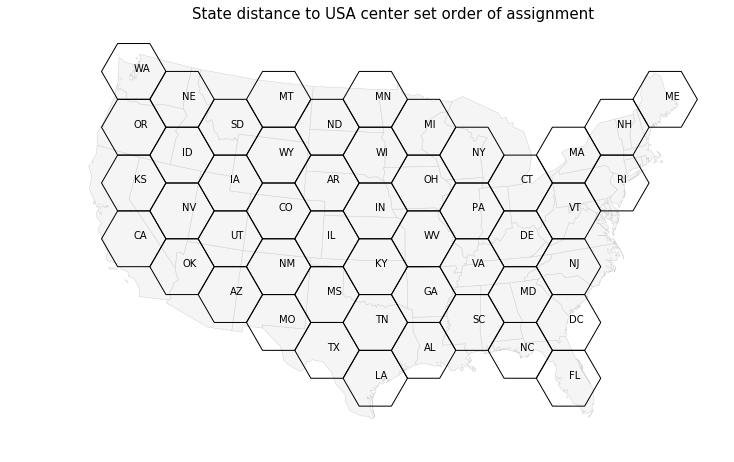

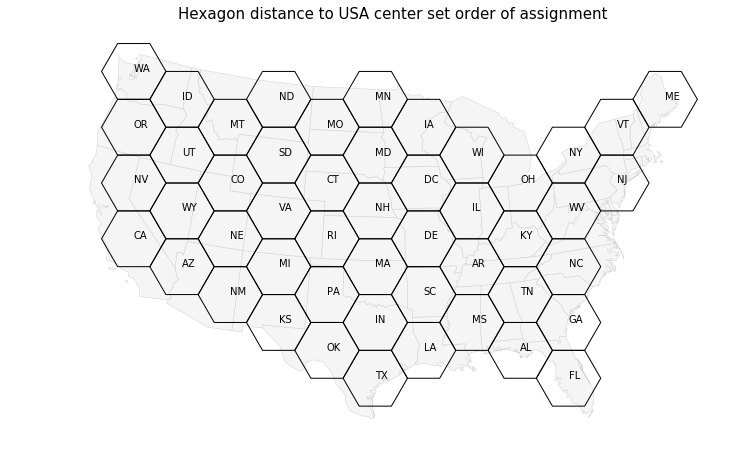

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title('State distance to USA center set order of assignment', 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
#bbox_gdf.plot(ax=ax, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_up.plot(ax=ax, edgecolor='black', facecolor="none")
hexagons_up[tile_id] = hexagons_up.index
display_point_labels(hexagons_up.set_geometry('geom_centroid'), admin_id_admin, c='black')


fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax2.set_title('Hexagon distance to USA center set order of assignment', 
                  fontdict={'fontsize': '15', 'fontweight' : '500'})
ax2.set_axis_off()
admin.set_geometry('geom_poly').plot(ax=ax2, linewidth=0.5, 
                                     edgecolor='lightgrey', color='whitesmoke')
#bbox_gdf.plot(ax=ax2, facecolor="none", edgecolor='lightgrey', linestyle=':')
hexagons_up.plot(ax=ax2, edgecolor='black', facecolor="none")
hexagons_up[tile_id] = hexagons_up.index
display_point_labels(hexagons_up.set_geometry('geom_centroid'), admin_id_tile, c='black')